## Makemore 1 - Exercises

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

## Exercise 1 - Trigram Language Model
**Objective**: Train a trigram language model, i.e. take two characters as an input to predict the 3rd one. Feel free to use either counting or a neural net. Evaluate the loss; Did it improve over a bigram model?

**Intuition**: model will be able to evaluate its choice for a next character based on more context. This should improve the loss over a bigram model.

In [32]:
# Set training device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

words = open('names.txt', 'r').read().splitlines()

In [10]:
for w in words[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): # Three char 'sliding-window'
        print(ch1, ch2, ch3)

. e m
e m m
m m a
m a .


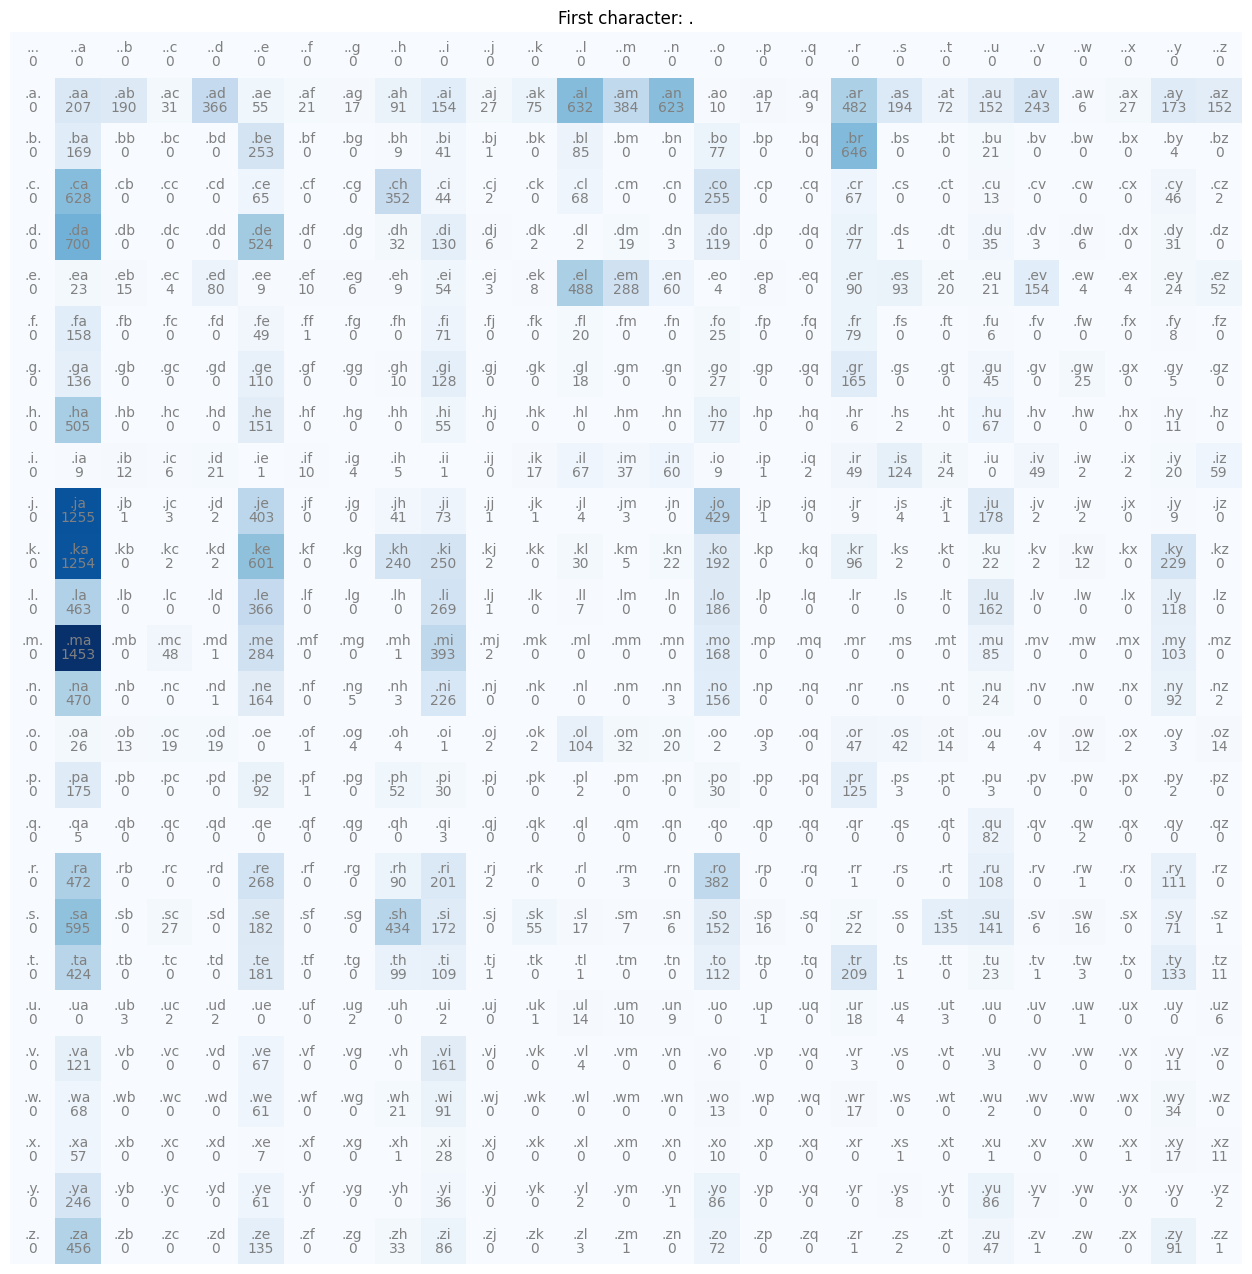

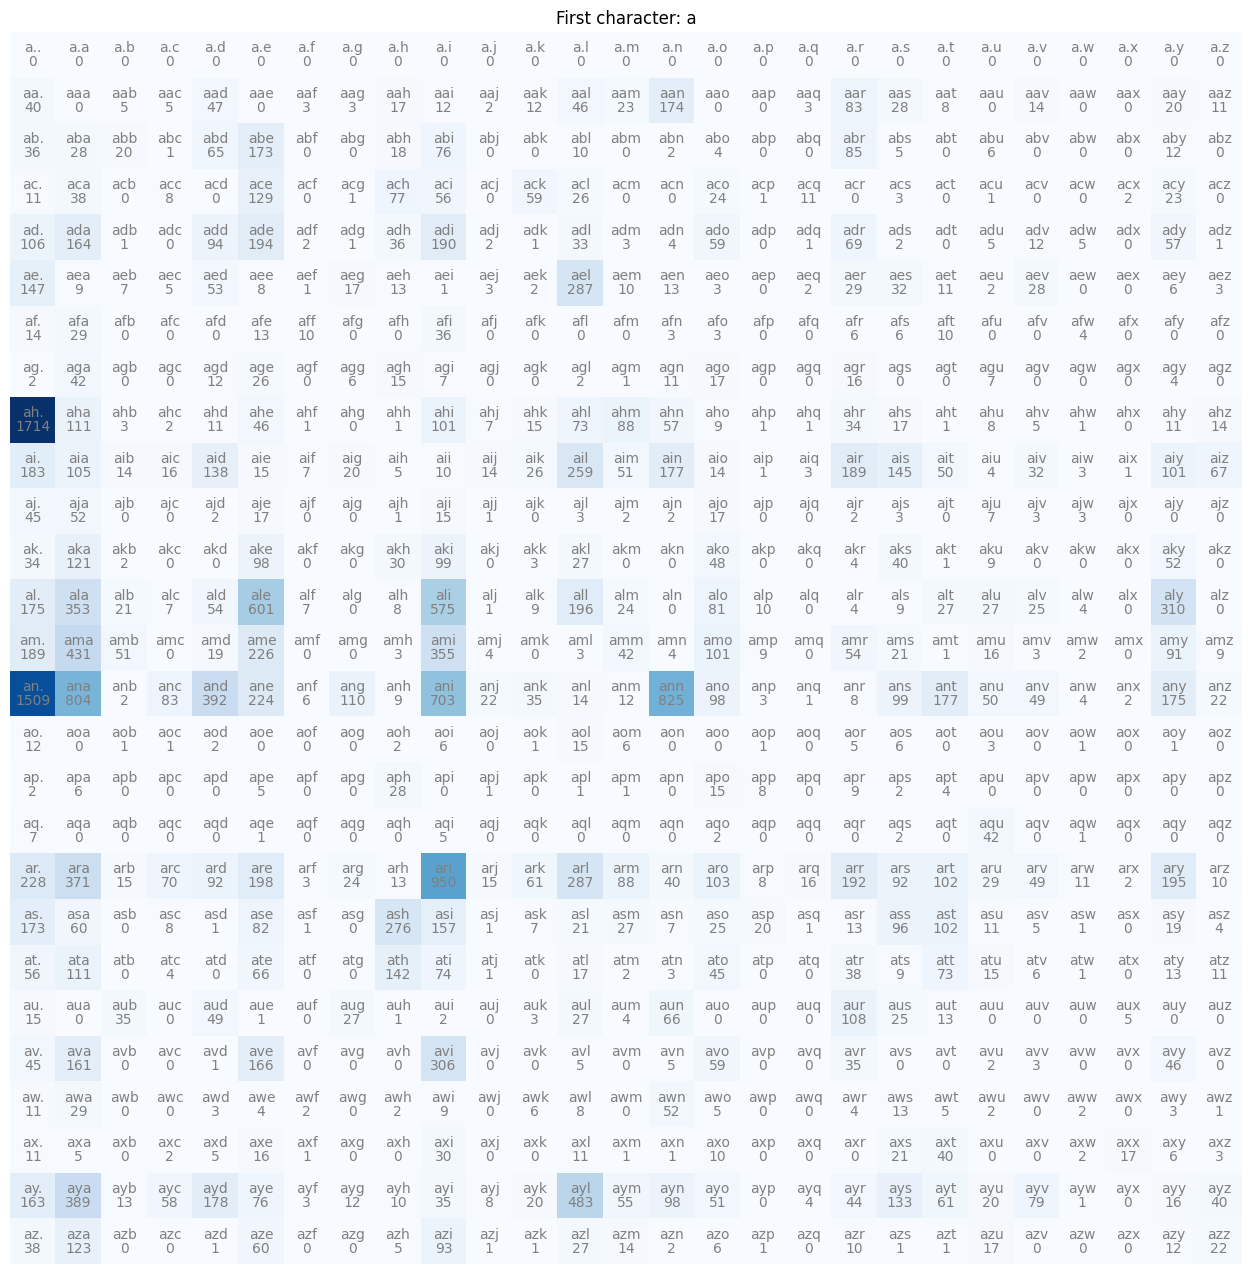

In [11]:
N = torch.zeros((27, 27, 27), dtype=torch.int32)

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0 # Special token has position zero
itos = {i:s for s,i in stoi.items()}

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]): # Three token 'sliding-window'
        N[stoi[ch1], stoi[ch2], stoi[ch3]] += 1 # Increment cell in 3D tensor by 1

# You can create 27 separate 2D heatmaps, one for each first character
# I will just create 2 for presentation purposes
for k in range(2): # 27
    plt.figure(figsize=(16, 16))
    plt.imshow(N[k], cmap='Blues')
    plt.title(f"First character: {itos[k]}")
    for i in range(27):
        for j in range(27):
            chstr = itos[k] + itos[i] + itos[j]
            plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
            plt.text(j, i, N[k,i,j].item(), ha="center", va="top", color="gray")
    plt.axis('off')
    plt.show()

In [12]:
# Create training set of all trigrams
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        xs.append([stoi[ch1], stoi[ch2]])
        ys.append(stoi[ch3])

xs, ys = torch.tensor(xs), torch.tensor(ys) # [196113, 2], [196113]
num_x, num_y = xs.nelement() // 2, ys.nelement()
print('number of examples\nx:', num_x, '\ny:', num_y)

number of examples
x: 196113 
y: 196113


In [15]:
g = torch.Generator(device=device).manual_seed(2147483647)
W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)

In [16]:
# Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
for k in range(200):
    # Forward pass
    xenc = F.one_hot(xs, num_classes=27).float().to(device) # One-hot encoding, [196113, 2, 27]
    xenc = xenc.view(num_x, -1) # concatenate the one-hot vectors, [196113, 54]
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(num_x), ys].log().mean() + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 4.216725826263428
Loss @ iteration 2: 3.398984670639038
Loss @ iteration 3: 3.0748445987701416
Loss @ iteration 4: 2.9019320011138916
Loss @ iteration 5: 2.7899904251098633
Loss @ iteration 6: 2.710465908050537
Loss @ iteration 7: 2.6509435176849365
Loss @ iteration 8: 2.604995012283325
Loss @ iteration 9: 2.568213939666748
Loss @ iteration 10: 2.537914752960205
Loss @ iteration 11: 2.512315034866333
Loss @ iteration 12: 2.4903595447540283
Loss @ iteration 13: 2.4713008403778076
Loss @ iteration 14: 2.4546525478363037
Loss @ iteration 15: 2.44002366065979
Loss @ iteration 16: 2.427126884460449
Loss @ iteration 17: 2.4157094955444336
Loss @ iteration 18: 2.4055705070495605
Loss @ iteration 19: 2.3965280055999756
Loss @ iteration 20: 2.3884339332580566
Loss @ iteration 21: 2.381155252456665
Loss @ iteration 22: 2.374584436416626
Loss @ iteration 23: 2.3686254024505615
Loss @ iteration 24: 2.3632004261016846
Loss @ iteration 25: 2.3582406044006348
Loss @ iteration 26: 

The bigram model had produced a loss of **2.4813051223754883**. \
The trigram model produces a loss of **2.2594664096832275**.

## Exercise 2 - Splitting the Dataset, Evaluation on Dev and Test Sets
**Objective**: Split up the dataset randomly into 
80% train set, 
10% dev set, 
10% test set.
Train the bigram and trigram models only on the training set. Evaluate them on dev and test splits. What can you see?

In [17]:
g = torch.Generator(device=device).manual_seed(2147483647)

In [18]:
# Create set of all *bigrams*
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(stoi[ch1])
        ys.append(stoi[ch2])

xs, ys = torch.tensor(xs), torch.tensor(ys) # [196113], [196113]
num_x, num_y = xs.nelement(), ys.nelement()

# Shuffle/Permute the dataset, keeping pairs in sync
perm = torch.randperm(num_x)
xs, ys = xs[perm], ys[perm]

# Split 80:10:10 for train:valid:test
xs_bi_train, xs_bi_valid, xs_bi_test = xs[:int(num_x * 0.8)], xs[int(num_x * 0.8):int(num_x * 0.9)], xs[int(num_x * 0.9):]
ys_bi_train, ys_bi_valid, ys_bi_test = ys[:int(num_x * 0.8)], ys[int(num_x * 0.8):int(num_x * 0.9)], ys[int(num_x * 0.9):]

In [19]:
W = torch.randn((27,27), device=device, generator=g, requires_grad=True)

# Training cycles, using the entire dataset -> 200 Epochs
for k in range(200):    
    # Forward pass
    xenc = F.one_hot(xs_bi_train, num_classes=27).float().to(device) # one-hot encode the names
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys_bi_train].log().mean() + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 3.7227370738983154
Loss @ iteration 2: 3.3692283630371094
Loss @ iteration 3: 3.144953966140747
Loss @ iteration 4: 3.004025936126709
Loss @ iteration 5: 2.908831834793091
Loss @ iteration 6: 2.83949875831604
Loss @ iteration 7: 2.7882468700408936
Loss @ iteration 8: 2.749513626098633
Loss @ iteration 9: 2.719315767288208
Loss @ iteration 10: 2.695000410079956
Loss @ iteration 11: 2.674886703491211
Loss @ iteration 12: 2.6579079627990723
Loss @ iteration 13: 2.643357515335083
Loss @ iteration 14: 2.6307406425476074
Loss @ iteration 15: 2.6196935176849365
Loss @ iteration 16: 2.609940767288208
Loss @ iteration 17: 2.6012699604034424
Loss @ iteration 18: 2.593513011932373
Loss @ iteration 19: 2.5865373611450195
Loss @ iteration 20: 2.580235242843628
Loss @ iteration 21: 2.5745184421539307
Loss @ iteration 22: 2.5693140029907227
Loss @ iteration 23: 2.564560651779175
Loss @ iteration 24: 2.5602059364318848
Loss @ iteration 25: 2.5562047958374023
Loss @ iteration 26: 2.

In [20]:
# Validation Loss
with torch.no_grad():
    xenc = F.one_hot(xs_bi_valid, num_classes=27).float().to(device) # one-hot encode the names
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys_bi_valid].log().mean() + 0.01 * (W**2).mean()
print(f'Validation Loss: {loss}')

# Test Loss
with torch.no_grad():
    xenc = F.one_hot(xs_bi_test, num_classes=27).float().to(device) # one-hot encode the names
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(len(probs)), ys_bi_test].log().mean() + 0.01 * (W**2).mean()
print(f'Test Loss:\t {loss}')

Validation Loss: 2.488346815109253
Test Loss:	 2.486797571182251


In [21]:
# Create set of all *trigrams*
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        xs.append([stoi[ch1], stoi[ch2]])
        ys.append(stoi[ch3])

xs, ys = torch.tensor(xs), torch.tensor(ys) # [196113, 2], [196113]
num_x, num_y = xs.nelement() // 2, ys.nelement()

# Shuffle/Permute the dataset, keeping (x,y) pairs in sync
perm = torch.randperm(num_x)
xs, ys = xs[perm,:], ys[perm] # xs are shuffled along the zeroth dimension

# Split 80:10:10 for train:valid:test
xs_tri_train, xs_tri_valid, xs_tri_test = xs[:int(num_x * 0.8),:], xs[int(num_x * 0.8):int(num_x * 0.9),:], xs[int(num_x * 0.9):,:]
ys_tri_train, ys_tri_valid, ys_tri_test = ys[:int(num_x * 0.8)], ys[int(num_x * 0.8):int(num_x * 0.9)], ys[int(num_x * 0.9):]

In [22]:
W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)

# Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
d_size = xs_tri_train.shape[0]
for k in range(200):
    # Forward pass
    xenc = F.one_hot(xs_tri_train, num_classes=27).float().to(device) # One-hot encoding, [196113, 2, 27]
    xenc = xenc.view(d_size, -1) # concatenate the one-hot vectors, [196113, 54]
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(d_size), ys_tri_train].log().mean() + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 4.067157745361328
Loss @ iteration 2: 3.3592822551727295
Loss @ iteration 3: 3.0655760765075684
Loss @ iteration 4: 2.887782573699951
Loss @ iteration 5: 2.7732741832733154
Loss @ iteration 6: 2.692700147628784
Loss @ iteration 7: 2.6333999633789062
Loss @ iteration 8: 2.588157892227173
Loss @ iteration 9: 2.5525684356689453
Loss @ iteration 10: 2.523695707321167
Loss @ iteration 11: 2.499701499938965
Loss @ iteration 12: 2.4793877601623535
Loss @ iteration 13: 2.4619579315185547
Loss @ iteration 14: 2.4468307495117188
Loss @ iteration 15: 2.4335780143737793
Loss @ iteration 16: 2.421869993209839
Loss @ iteration 17: 2.411457061767578
Loss @ iteration 18: 2.402139902114868
Loss @ iteration 19: 2.3937623500823975
Loss @ iteration 20: 2.386194944381714
Loss @ iteration 21: 2.37933087348938
Loss @ iteration 22: 2.3730809688568115
Loss @ iteration 23: 2.3673698902130127
Loss @ iteration 24: 2.3621325492858887
Loss @ iteration 25: 2.357314109802246
Loss @ iteration 26: 2

In [23]:
# Validation Loss
d_size = xs_tri_valid.shape[0]
with torch.no_grad():
    xenc = F.one_hot(xs_tri_valid, num_classes=27).float().to(device) # one-hot encode the names
    xenc = xenc.view(d_size, -1)
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(d_size), ys_tri_valid].log().mean() + 0.01 * (W**2).mean()
print(f'Validation Loss: {loss}')

# Test Loss
d_size = xs_tri_test.shape[0]
with torch.no_grad():
    xenc = F.one_hot(xs_tri_test, num_classes=27).float().to(device) # one-hot encode the names
    xenc = xenc.view(d_size, -1)
    logits = xenc @ W # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(d_size), ys_tri_test].log().mean() + 0.01 * (W**2).mean()
print(f'Test Loss:\t {loss}')

Validation Loss: 2.2705209255218506
Test Loss:	 2.2631025314331055


Both the validation and test loss are higher than the training loss. 

However, they only differ by a small margin, which leaves us with a good sign for the trigram model's generalization. 

However, we can intuitively see how the increase in model complexity can affect the generalization of the model. 

Still, in this particular case, the additional context provided by the trigram model seems to be quite beneficial for the generalization, as the loss is only ever so slightly higher than the training loss.

## Exercise 3 - Tuning the Strength of Smoothing
**Objective**: Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e.
try many possibilities and see which one works best based on the dev set loss.
What patterns can you see in the train and dev set loss as you tune this strength?
Take the best setting of the smoothing and evaluate on the test set once and at the end.
How good of a loss do you achieve?

In [27]:
# Create set of all *trigrams*
xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2, ch3 in zip(chs, chs[1:], chs[2:]):
        xs.append([stoi[ch1], stoi[ch2]])
        ys.append(stoi[ch3])

xs, ys = torch.tensor(xs), torch.tensor(ys) # [196113, 2], [196113]
num_x, num_y = xs.nelement() // 2, ys.nelement()

# Shuffle/Permute the dataset, keeping (x,y) pairs in sync
perm = torch.randperm(num_x)
xs, ys = xs[perm,:], ys[perm] # xs are shuffled along the zeroth dimension

# Split 80:10:10 for train:valid:test
xs_tri_train, xs_tri_valid, xs_tri_test = xs[:int(num_x * 0.8),:], xs[int(num_x * 0.8):int(num_x * 0.9),:], xs[int(num_x * 0.9):,:]
ys_tri_train, ys_tri_valid, ys_tri_test = ys[:int(num_x * 0.8)], ys[int(num_x * 0.8):int(num_x * 0.9)], ys[int(num_x * 0.9):]

In [28]:
# from 0.0 to 1.0 in 25 steps
strengths = torch.linspace(0.0, 1.0, 25, device=device)
losst, lossv, lossf = [], [], []

for strength in tqdm(strengths, desc='Training Strengths'):
    W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)

    # Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
    d_size = xs_tri_train.shape[0]
    for k in range(200):
        # Forward pass
        xenc = F.one_hot(xs_tri_train, num_classes=27).float().to(device) # One-hot encoding, [196113, 2, 27]
        xenc = xenc.view(d_size, -1) # concatenate the one-hot vectors, [196113, 54]
        logits = xenc @ W # logits, different word for log-counts
        counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
        probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
        loss_t = -probs[torch.arange(d_size), ys_tri_train].log().mean() + strength * (W**2).mean()
        
        # Backward pass
        W.grad = None # Make sure all gradients are reset
        loss_t.backward() # Torch kept track of what this variable is, kinda cool
        
        # Weight update
        W.data += -50 * W.grad

    # Validation Loss
    d_size = xs_tri_valid.shape[0]
    with torch.no_grad():
        xenc = F.one_hot(xs_tri_valid, num_classes=27).float().to(device) # one-hot encode the names
        xenc = xenc.view(d_size, -1)
        logits = xenc @ W # logits, different word for log-counts
        counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
        probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
        loss_v = -probs[torch.arange(d_size), ys_tri_valid].log().mean() + strength * (W**2).mean()

    # Test Loss
    d_size = xs_tri_test.shape[0]
    with torch.no_grad():
        xenc = F.one_hot(xs_tri_test, num_classes=27).float().to(device) # one-hot encode the names
        xenc = xenc.view(d_size, -1)
        logits = xenc @ W # logits, different word for log-counts
        counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
        probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
        loss_f = -probs[torch.arange(d_size), ys_tri_test].log().mean() + strength * (W**2).mean()

    # Note the losses for this strength
    losst.append((strength, loss_t))
    lossv.append((strength, loss_v))
    lossf.append((strength, loss_f))

Training Strengths: 100%|██████████| 25/25 [01:52<00:00,  4.51s/it]


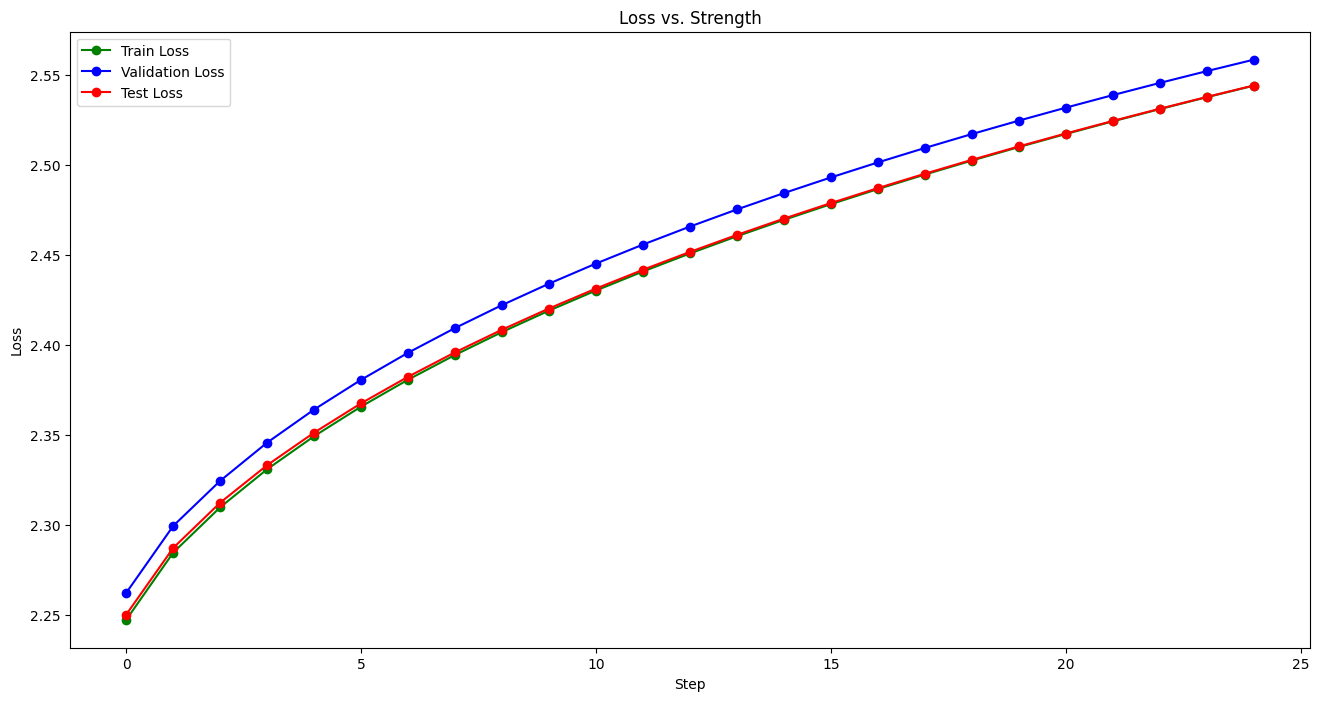

Best Strength: 0.0 @ Train: 2.2472493648529053, Validation: 2.262202262878418 & Test: 2.2501261234283447


In [29]:
# Plot the losses
plt.figure(figsize=(16, 8))
plt.plot([y.item() for (_, y) in losst], label='Train Loss', linestyle='-', marker='o', color='green')
plt.plot([y.item() for (_, y) in lossv], label='Validation Loss', linestyle='-', marker='o', color='blue')
plt.plot([y.item() for (_, y) in lossf], label='Test Loss', linestyle='-', marker='o', color='red')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss vs. Strength')
plt.legend()
plt.show()

# Report the best strength
print(f'Best Strength: {min(lossv, key=lambda x: x[1])[0]} @ Train: {min(losst, key=lambda x: x[1])[1]}, Validation: {min(lossv, key=lambda x: x[1])[1]} & Test: {min(lossf, key=lambda x: x[1])[1]}')

## Exercise 4 - One-Hot Vector Delete

**Objective:** We saw that our one-hot vectors merely select a row of $W$, so producing these vectors explicitly feels wasteful.<br>
Can you delete our use of `F.one_hot` in favor of simply indexing into rows of $W$?

In [30]:
W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)

# Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
d_size = xs_tri_train.shape[0]
for k in range(200):
    # Forward pass
    logits = W[xs_tri_train[:,0]] + W[27 + xs_tri_train[:,1]] # logits, different word for log-counts
    counts = logits.exp() # 'fake counts', kinda like in  the N matrix of bigram
    probs = counts / counts.sum(1, keepdims=True) # Normal distribution probabilities (this is y_pred)
    loss = -probs[torch.arange(d_size), ys_tri_train].log().mean() + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 4.182826519012451
Loss @ iteration 2: 3.4183080196380615
Loss @ iteration 3: 3.091275453567505
Loss @ iteration 4: 2.911158323287964
Loss @ iteration 5: 2.7965123653411865
Loss @ iteration 6: 2.7158312797546387
Loss @ iteration 7: 2.656838893890381
Loss @ iteration 8: 2.610440731048584
Loss @ iteration 9: 2.573568105697632
Loss @ iteration 10: 2.5428342819213867
Loss @ iteration 11: 2.517301082611084
Loss @ iteration 12: 2.49536395072937
Loss @ iteration 13: 2.4766087532043457
Loss @ iteration 14: 2.460162878036499
Loss @ iteration 15: 2.445805072784424
Loss @ iteration 16: 2.433032989501953
Loss @ iteration 17: 2.421708106994629
Loss @ iteration 18: 2.4115235805511475
Loss @ iteration 19: 2.40238094329834
Loss @ iteration 20: 2.3940863609313965
Loss @ iteration 21: 2.3865654468536377
Loss @ iteration 22: 2.3796911239624023
Loss @ iteration 23: 2.3734076023101807
Loss @ iteration 24: 2.3676295280456543
Loss @ iteration 25: 2.3623132705688477
Loss @ iteration 26: 2.3

## Exercise 5: Using F.cross_entropy

**Objective:** Look up and use `F.cross_entropy` instead. You should achieve the same result. Can you think of why we'd prefer to use `F.cross_entropy` instead? Here's the [documentation on `F.cross_entropy`](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html).<br>
The function expects the logits as input, and the target labels as the second input.

In [34]:
W = torch.randn((27+27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)
ys_tri_train = ys_tri_train.to(device) 

# Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
d_size = xs_tri_train.shape[0]
for k in range(200):
    # Forward pass
    logits = W[xs_tri_train[:,0]] + W[27 + xs_tri_train[:,1]] # logits, different word for log-counts
    loss = F.cross_entropy(logits, ys_tri_train) + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 4.268058776855469
Loss @ iteration 2: 3.4533469676971436
Loss @ iteration 3: 3.1064393520355225
Loss @ iteration 4: 2.9026286602020264
Loss @ iteration 5: 2.777003765106201
Loss @ iteration 6: 2.6935675144195557
Loss @ iteration 7: 2.6337220668792725
Loss @ iteration 8: 2.5879034996032715
Loss @ iteration 9: 2.551600933074951
Loss @ iteration 10: 2.5222043991088867
Loss @ iteration 11: 2.4980053901672363
Loss @ iteration 12: 2.477761745452881
Loss @ iteration 13: 2.460573434829712
Loss @ iteration 14: 2.4457650184631348
Loss @ iteration 15: 2.432856321334839
Loss @ iteration 16: 2.4214634895324707
Loss @ iteration 17: 2.4113028049468994
Loss @ iteration 18: 2.40217661857605
Loss @ iteration 19: 2.3939270973205566
Loss @ iteration 20: 2.386415719985962
Loss @ iteration 21: 2.379563331604004
Loss @ iteration 22: 2.373267650604248
Loss @ iteration 23: 2.3674747943878174
Loss @ iteration 24: 2.362123727798462
Loss @ iteration 25: 2.3571674823760986
Loss @ iteration 26: 

## Exercise 6: Meta Exercise

**Objective:** Think of a fun/interesting exercise and complete it.

What would happen if instead of using a $54\times 27$ weight matrix, we used a $27\times 27$ weight matrix for the trigram model?<br>
Theoretically, weight optimizations would be easier, but how well can the positional information be represented in such a bigram-like model size?

In [35]:
W = torch.randn((27,27), device=device, generator=g, requires_grad=True) # random column tensor of (27+27)x27 numbers (requires_grad=True for autograd)

# Training cycles, using the entire dataset -> 200 Epochs, like the bigram model
d_size = xs_tri_train.shape[0]
for k in range(200):
    # Forward pass
    logits = W[xs_tri_train[:,0]] + W[xs_tri_train[:,1]] # logits, different word for log-counts
    loss = F.cross_entropy(logits, ys_tri_train) + 0.01 * (W**2).mean()
    print(f'Loss @ iteration {k+1}: {loss}')
    
    # Backward pass
    W.grad = None # Make sure all gradients are reset
    loss.backward() # Torch kept track of what this variable is, kinda cool
    
    # Weight update
    W.data += -50 * W.grad

Loss @ iteration 1: 4.440183639526367
Loss @ iteration 2: 3.361849069595337
Loss @ iteration 3: 3.0922162532806396
Loss @ iteration 4: 2.950259208679199
Loss @ iteration 5: 3.054370403289795
Loss @ iteration 6: 2.713991165161133
Loss @ iteration 7: 2.692291259765625
Loss @ iteration 8: 2.704861879348755
Loss @ iteration 9: 2.8743882179260254
Loss @ iteration 10: 2.606074810028076
Loss @ iteration 11: 2.630896806716919
Loss @ iteration 12: 2.6584789752960205
Loss @ iteration 13: 2.8581719398498535
Loss @ iteration 14: 2.553767442703247
Loss @ iteration 15: 2.5484681129455566
Loss @ iteration 16: 2.5719690322875977
Loss @ iteration 17: 2.7257091999053955
Loss @ iteration 18: 2.558389663696289
Loss @ iteration 19: 2.665309429168701
Loss @ iteration 20: 2.5817394256591797
Loss @ iteration 21: 2.7559380531311035
Loss @ iteration 22: 2.5252885818481445
Loss @ iteration 23: 2.5813024044036865
Loss @ iteration 24: 2.608116626739502
Loss @ iteration 25: 2.817793369293213
Loss @ iteration 26: 2.

The results are clear, and they are **not good**.<br>
The training loss is significantly higher than the original trigram model. But more importantly, training behavior has become erratic and unstable.<br>
Therefore, we can say that scaling our trigram's `W` along the input sequence dimension is crucial for the model's performance and reliability.